<a href="https://colab.research.google.com/github/sameer-karim/w207-final-project/blob/project/DT_car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data manipulation and numerical operations
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and statistical models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_percentage_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from tabulate import tabulate
import re

In [2]:
# Path to your file
# Load the data into a DataFrame
df = pd.read_csv('C:/Users/sameer/Desktop/UCB_MIDS/w207/w207-final-project/Data/car_price_prediction.csv')

df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [4]:
print(df.isnull().sum())

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [5]:
#Data Preprocessing and Splits
#remove km and convert from string to int
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype(int)

# Function to remove 'turbo' and convert to numeric
def clean_engine(value):
    if 'turbo' in value:
        value = value.replace(' turbo', '')
    return pd.to_numeric(value, errors='coerce')

# Apply the function to the 'Engine' column
df['Engine volume'] = df['Engine volume'].apply(clean_engine)

#convert doors from string to numeric
# Function to extract numbers from strings
def extract_numbers(column):
    return column.apply(lambda x: re.findall(r'\d+', x)[0])
#apply doors extraction function to column and re-type as a float
df['Doors'] = extract_numbers(df['Doors']).astype(float)

# NOTE THAT THERE ARE ALWAYS TAXES AND FEES SO WE NEED TO DISCUSS WHAT TO DO WITH THIS COLUMN WHEN 0 OR JUST LEAVE IT AND CALL IT OUT IN PRESENTATION
# Replace non-numeric values (e.g., '-') for the Levy Column - the Levy column is taxes and fees upon purchase
df.replace('-', 0, inplace=True)


# Convert appropriate columns to numeric types (assuming these columns are supposed to be numeric)
#['ID', 'Levy','Price', 'Prod. year', 'Cylinders', 'Airbags','Engine volume', 'Mileage','Doors']
columns_to_convert=['ID', 'Levy','Price', 'Prod. year', 'Cylinders', 'Airbags','Engine volume', 'Mileage','Doors']

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column])

# Drop rows with missing values - there are none but we can leave this here anyway
df.dropna(inplace=True)

# Calculate car age
#df['car_age'] = 2024 - df['Prod. year']
#drop prod year - optional
#df = df.drop(columns=['Prod. year'])

# Mileage per year
#df['mileage_per_year'] = df['Mileage'] / df['car_age']

#drive train rename
df['Drive wheels'] = df['Drive wheels'].replace('4x4', '4WD')

# List of categorical columns
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

In [6]:
numerical_features = ['ID', 'Levy','Price', 'Prod. year', 'Cylinders', 'Airbags','Engine volume', 'Mileage','Doors']

In [7]:
negative_prices = df[df['Price'] < 0]
negative_id = df[df['ID'] < 0]
negative_levy = df[df['Levy'] < 0]
negative_year = df[df['Prod. year'] < 0]
negative_cylinders = df[df['Cylinders'] < 0]
negative_airbags = df[df['Airbags'] < 0]
negative_mileage = df[df['Mileage'] < 0]
negative_engine = df[df['Engine volume'] < 0]
negative_doors = df[df['Doors'] < 0]

print(negative_prices)
print(negative_prices)
print(negative_id)
print(negative_levy)
print(negative_year)
print(negative_cylinders)
print(negative_airbags)
print(negative_mileage)
print(negative_engine)
print(negative_doors)

Empty DataFrame
Columns: [ID, Price, Levy, Manufacturer, Model, Prod. year, Category, Leather interior, Fuel type, Engine volume, Mileage, Cylinders, Gear box type, Drive wheels, Doors, Wheel, Color, Airbags]
Index: []
Empty DataFrame
Columns: [ID, Price, Levy, Manufacturer, Model, Prod. year, Category, Leather interior, Fuel type, Engine volume, Mileage, Cylinders, Gear box type, Drive wheels, Doors, Wheel, Color, Airbags]
Index: []
Empty DataFrame
Columns: [ID, Price, Levy, Manufacturer, Model, Prod. year, Category, Leather interior, Fuel type, Engine volume, Mileage, Cylinders, Gear box type, Drive wheels, Doors, Wheel, Color, Airbags]
Index: []
Empty DataFrame
Columns: [ID, Price, Levy, Manufacturer, Model, Prod. year, Category, Leather interior, Fuel type, Engine volume, Mileage, Cylinders, Gear box type, Drive wheels, Doors, Wheel, Color, Airbags]
Index: []
Empty DataFrame
Columns: [ID, Price, Levy, Manufacturer, Model, Prod. year, Category, Leather interior, Fuel type, Engine vo

## Decision Tree Implementation

In [7]:
# Initialize the Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# Initialize the model - this is just a baseline metric to base hyperparameter tuning
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
dt_regressor.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = dt_regressor.predict(X_val)

# Calculate Mean Absolute Percentage Error (MAPE) on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')

Validation MAPE: 127480.64%


In [8]:
# Predict on the test set
y_test_pred = dt_regressor.predict(X_test)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 1266.04%


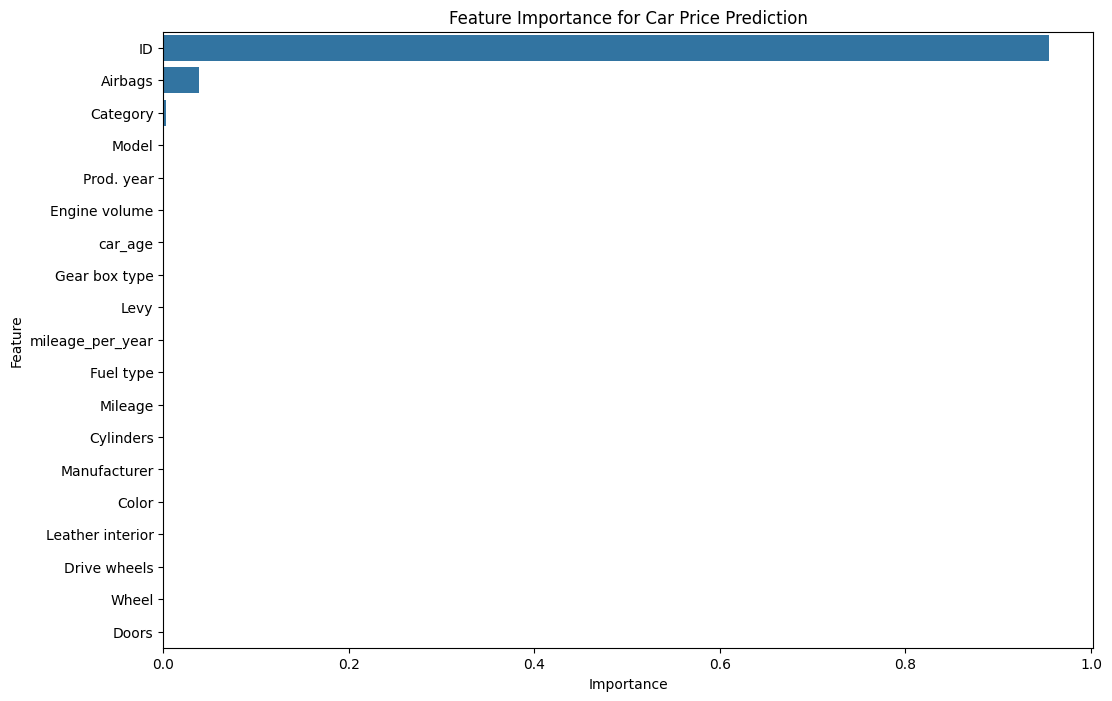

In [9]:
# Feature importance
feature_importances = dt_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction')
plt.show()


In [8]:
# With the ID having an overwhelming proportion of the importance, lets drop the column
df = df.drop(columns=['ID'])

In [9]:
# Split labels again after dropping 'ID'
column_names_list = list(df.columns)
column_names_list.remove('Price')
X = df[column_names_list]
Y = df['Price']

# Split the data into training and validation sets 60/20/20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [12]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = dt_regressor.predict(X_val)

# Calculate Mean Absolute Percentage Error (MAPE) on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')


Validation MAPE: 849.06%


In [13]:
# Predict on the test set
y_test_pred = dt_regressor.predict(X_test)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 1277.73%


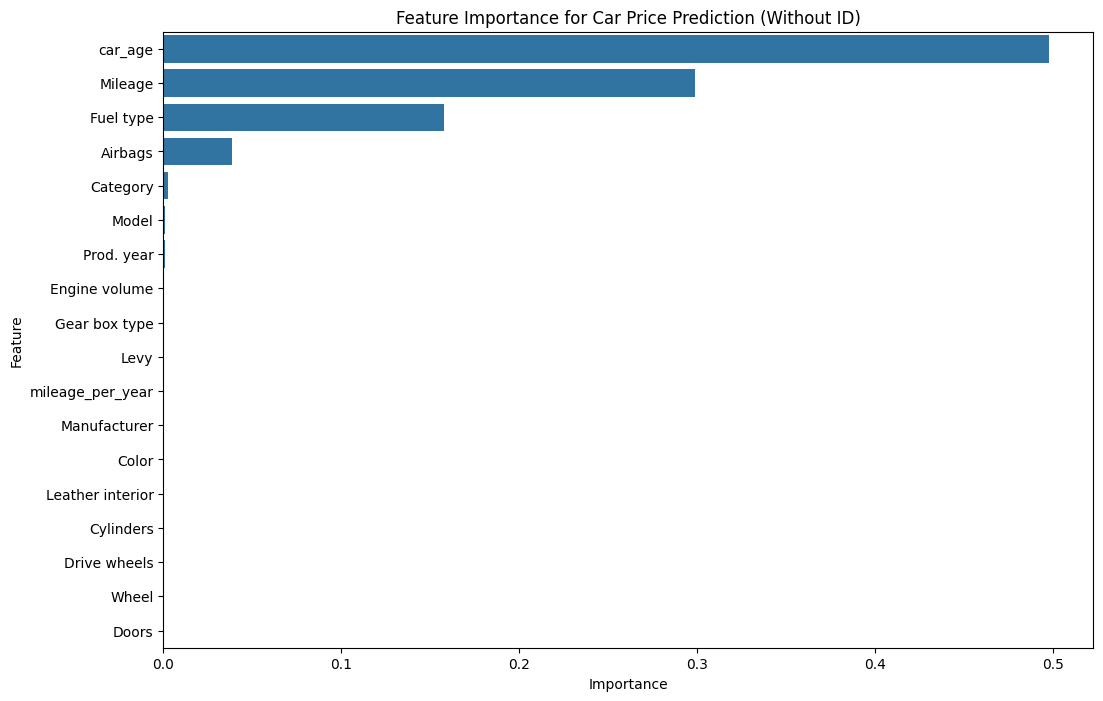

In [14]:
# Feature importance after removing 'ID'
feature_importances = dt_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction (Without ID)')
plt.show()

#### Much better MAPE metric after the ID column was dropped. The feature importance plot shows that car age, mileage, fuel type, and airbags are the top features influencing the the metric. However the metric is still quite high. Since MAPE is still so high, we will pivot to using a Random Forest Regressor. It is an ensemble method that can hopefully capture the complexity of the dataset after some hyperparameter tuning.

#### More Data Preprocessing

In [10]:
# List of categorical columns
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Initialize the label encoder
label_encoders = {}

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


ValueError: could not convert string to float: 'HYUNDAI'

#### Training and Baseline Modeling

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = rf_regressor.predict(X_val_scaled)

# Calculate MAPE on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')

Validation MAPE: 1004.70%


In [17]:
# Predict on the test set
y_test_pred = rf_regressor.predict(X_test_scaled)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 8778.71%


### Feature Importance

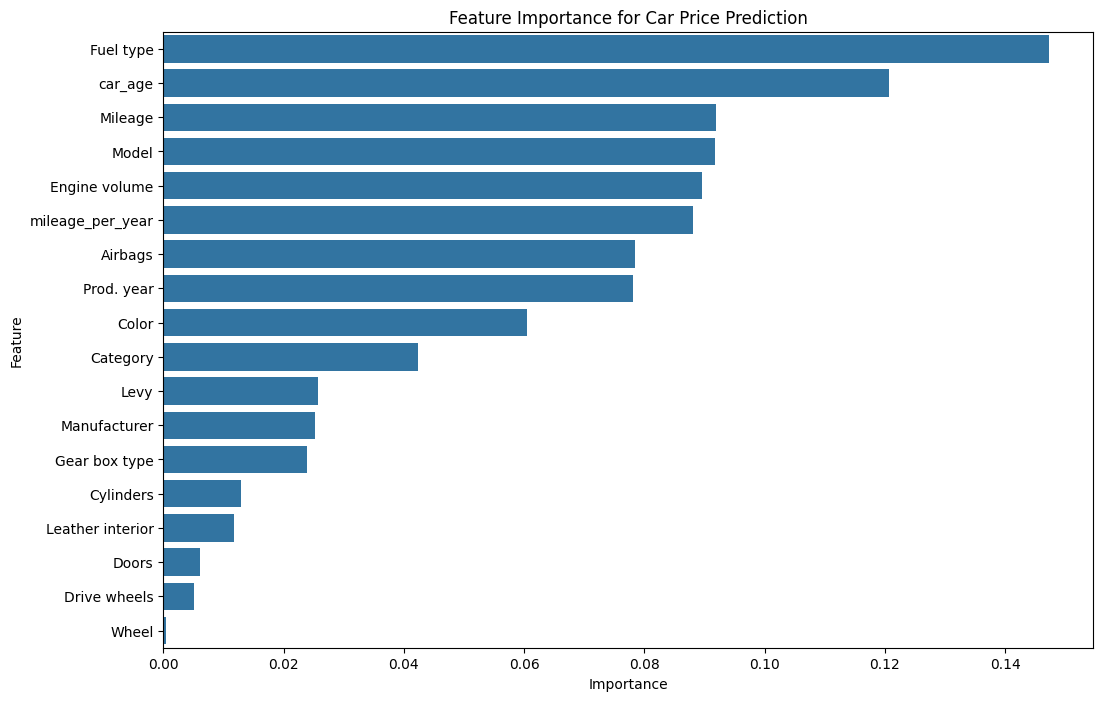

In [18]:
# Feature importance
feature_importances = rf_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction')
plt.show()

##### Quite a bit more balanced than the initial DT model created earlier. However, with MAPE values being so high we need to tune hyperparameters.

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_distributions,
    n_iter=20,  # Reduced number of parameter settings to sample
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    random_state=42
)


# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Best parameters found
print("Best Parameters:", random_search.best_params_)

# Best score achieved
print("Best Score (Negative MAPE):", random_search.best_score_)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 50, 'bootstrap': False}
Best Score (Negative MAPE): -9.408970842738832


In [20]:
# Get the best model
best_rf_model = random_search.best_estimator_

# Predict and evaluate
y_val_pred = best_rf_model.predict(X_val_scaled)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE with Tuning: {val_mape:.2%}')

y_test_pred = best_rf_model.predict(X_test_scaled)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE with Tuning: {test_mape:.2%}')

Validation MAPE with Tuning: 879.90%
Test MAPE with Tuning: 1064.98%


##### MAPE values still quite high, although the test MAPE has been fine-tuned quite a bit. We may have to revisit feature engineering to establish a better baseline.

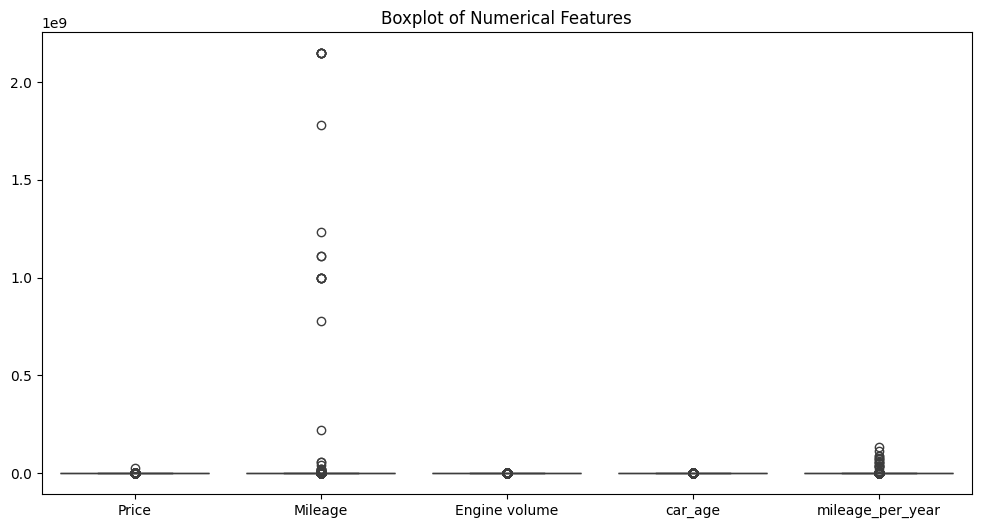

In [21]:
# Boxplot for numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Price', 'Mileage', 'Engine volume', 'car_age', 'mileage_per_year']])
plt.title('Boxplot of Numerical Features')
plt.show()


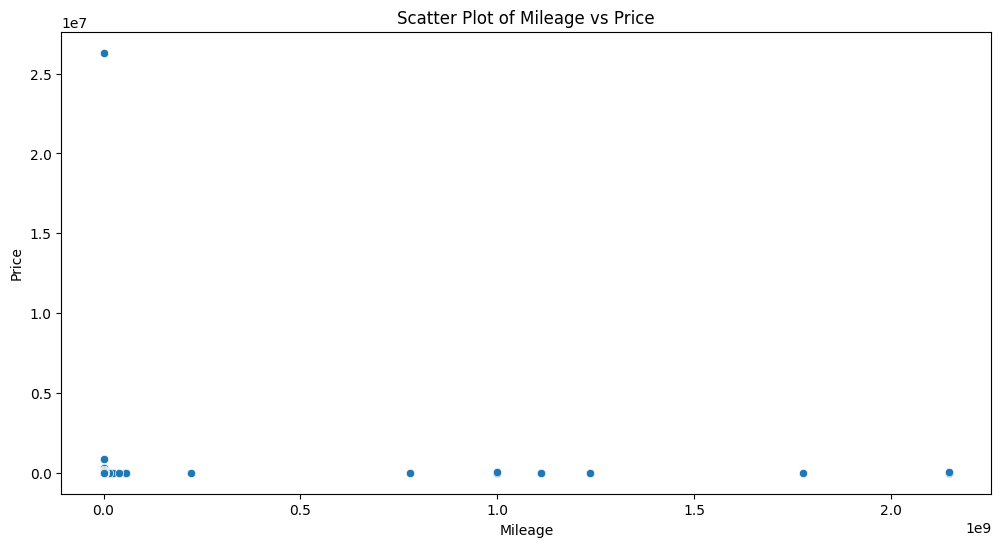

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Mileage', y='Price', data=df)
plt.title('Scatter Plot of Mileage vs Price')
plt.show()

In [11]:
from scipy.stats import zscore

df['Price_zscore'] = zscore(df['Price'])
df['Mileage_zscore'] = zscore(df['Mileage'])

# Identify outliers
price_outliers = df[np.abs(df['Price_zscore']) > 3]
mileage_outliers = df[np.abs(df['Mileage_zscore']) > 3]
print(f'Number of outliers in Price: {price_outliers.shape[0]}')
print(f'Number of outliers in Mileage: {mileage_outliers.shape[0]}')


Number of outliers in Price: 2
Number of outliers in Mileage: 17


In [12]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df[(df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR))]
print(f'Number of outliers in Price using IQR: {outliers.shape[0]}')


Number of outliers in Price using IQR: 914


In [13]:
# Check unique values for a categorical column
print(df['Manufacturer'].unique())

[31  8 20 16 22 57 35 41 44  5  3 40 54 11 27 38 53 45 34 18 15 60 23  1
 55 26  0 32 59 17 10 13 37  9 25 30 24 52 12  6 56  7 42 21 50 61  4 63
 58 36 62 47 51 29 33 14 28 39 46 43 49 48  2 19]


In [14]:
print(df.dtypes)

Price                 int64
Levy                  int64
Manufacturer          int32
Model                 int32
Prod. year            int64
Category              int32
Leather interior      int32
Fuel type             int32
Engine volume       float64
Mileage               int32
Cylinders           float64
Gear box type         int32
Drive wheels          int32
Doors               float64
Wheel                 int32
Color                 int32
Airbags               int64
Price_zscore        float64
Mileage_zscore      float64
dtype: object


In [15]:
le = LabelEncoder()
df['Manufacturer_encoded'] = le.fit_transform(df['Manufacturer'])
print(df[['Manufacturer', 'Manufacturer_encoded']].drop_duplicates())

       Manufacturer  Manufacturer_encoded
0                31                    31
1                 8                     8
2                20                    20
3                16                    16
5                22                    22
...             ...                   ...
12182            43                    43
12336            49                    49
12534            48                    48
13325             2                     2
18781            19                    19

[64 rows x 2 columns]


In [16]:
df.shape

(17306, 20)

In [17]:
# Applying a filter to the dataset to help remove outliers in the target variable
df_cleaned = df[(df['Price'] >= (Q1 - 1.5 * IQR)) & (df['Price'] <= (Q3 + 1.5 * IQR))]

In [18]:
df_cleaned.columns

Index(['Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags', 'Price_zscore', 'Mileage_zscore', 'Manufacturer_encoded'],
      dtype='object')

In [19]:
# Drop original target-related columns if necessary
df_cleaned = df_cleaned.drop(columns=['Price_zscore', 'Manufacturer'])

# Recalculate features and labels
column_names_list = list(df_cleaned.columns)
column_names_list.remove('Price')
X = df_cleaned[column_names_list]
y = df_cleaned['Price']

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [20]:
df_cleaned.shape

(16392, 18)

In [21]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

X_train shape: (9834, 17)
X_val shape: (3279, 17)
X_test shape: (3279, 17)
y_train shape: (9834,)
y_val shape: (3279,)
y_test shape: (3279,)


#### Our sets have a total of ~16,000 rows, with the training set with over 9000 rows. This should be a good amount to run a RandomizedSearchCV to find optimal hyperparameters. GridSearchCV was considered, but we are limited in our computation capabilities. First, let's take an overall look in our cleaned dataset again.

In [22]:
df_cleaned.columns

Index(['Price', 'Levy', 'Model', 'Prod. year', 'Category', 'Leather interior',
       'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
       'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Mileage_zscore',
       'Manufacturer_encoded'],
      dtype='object')

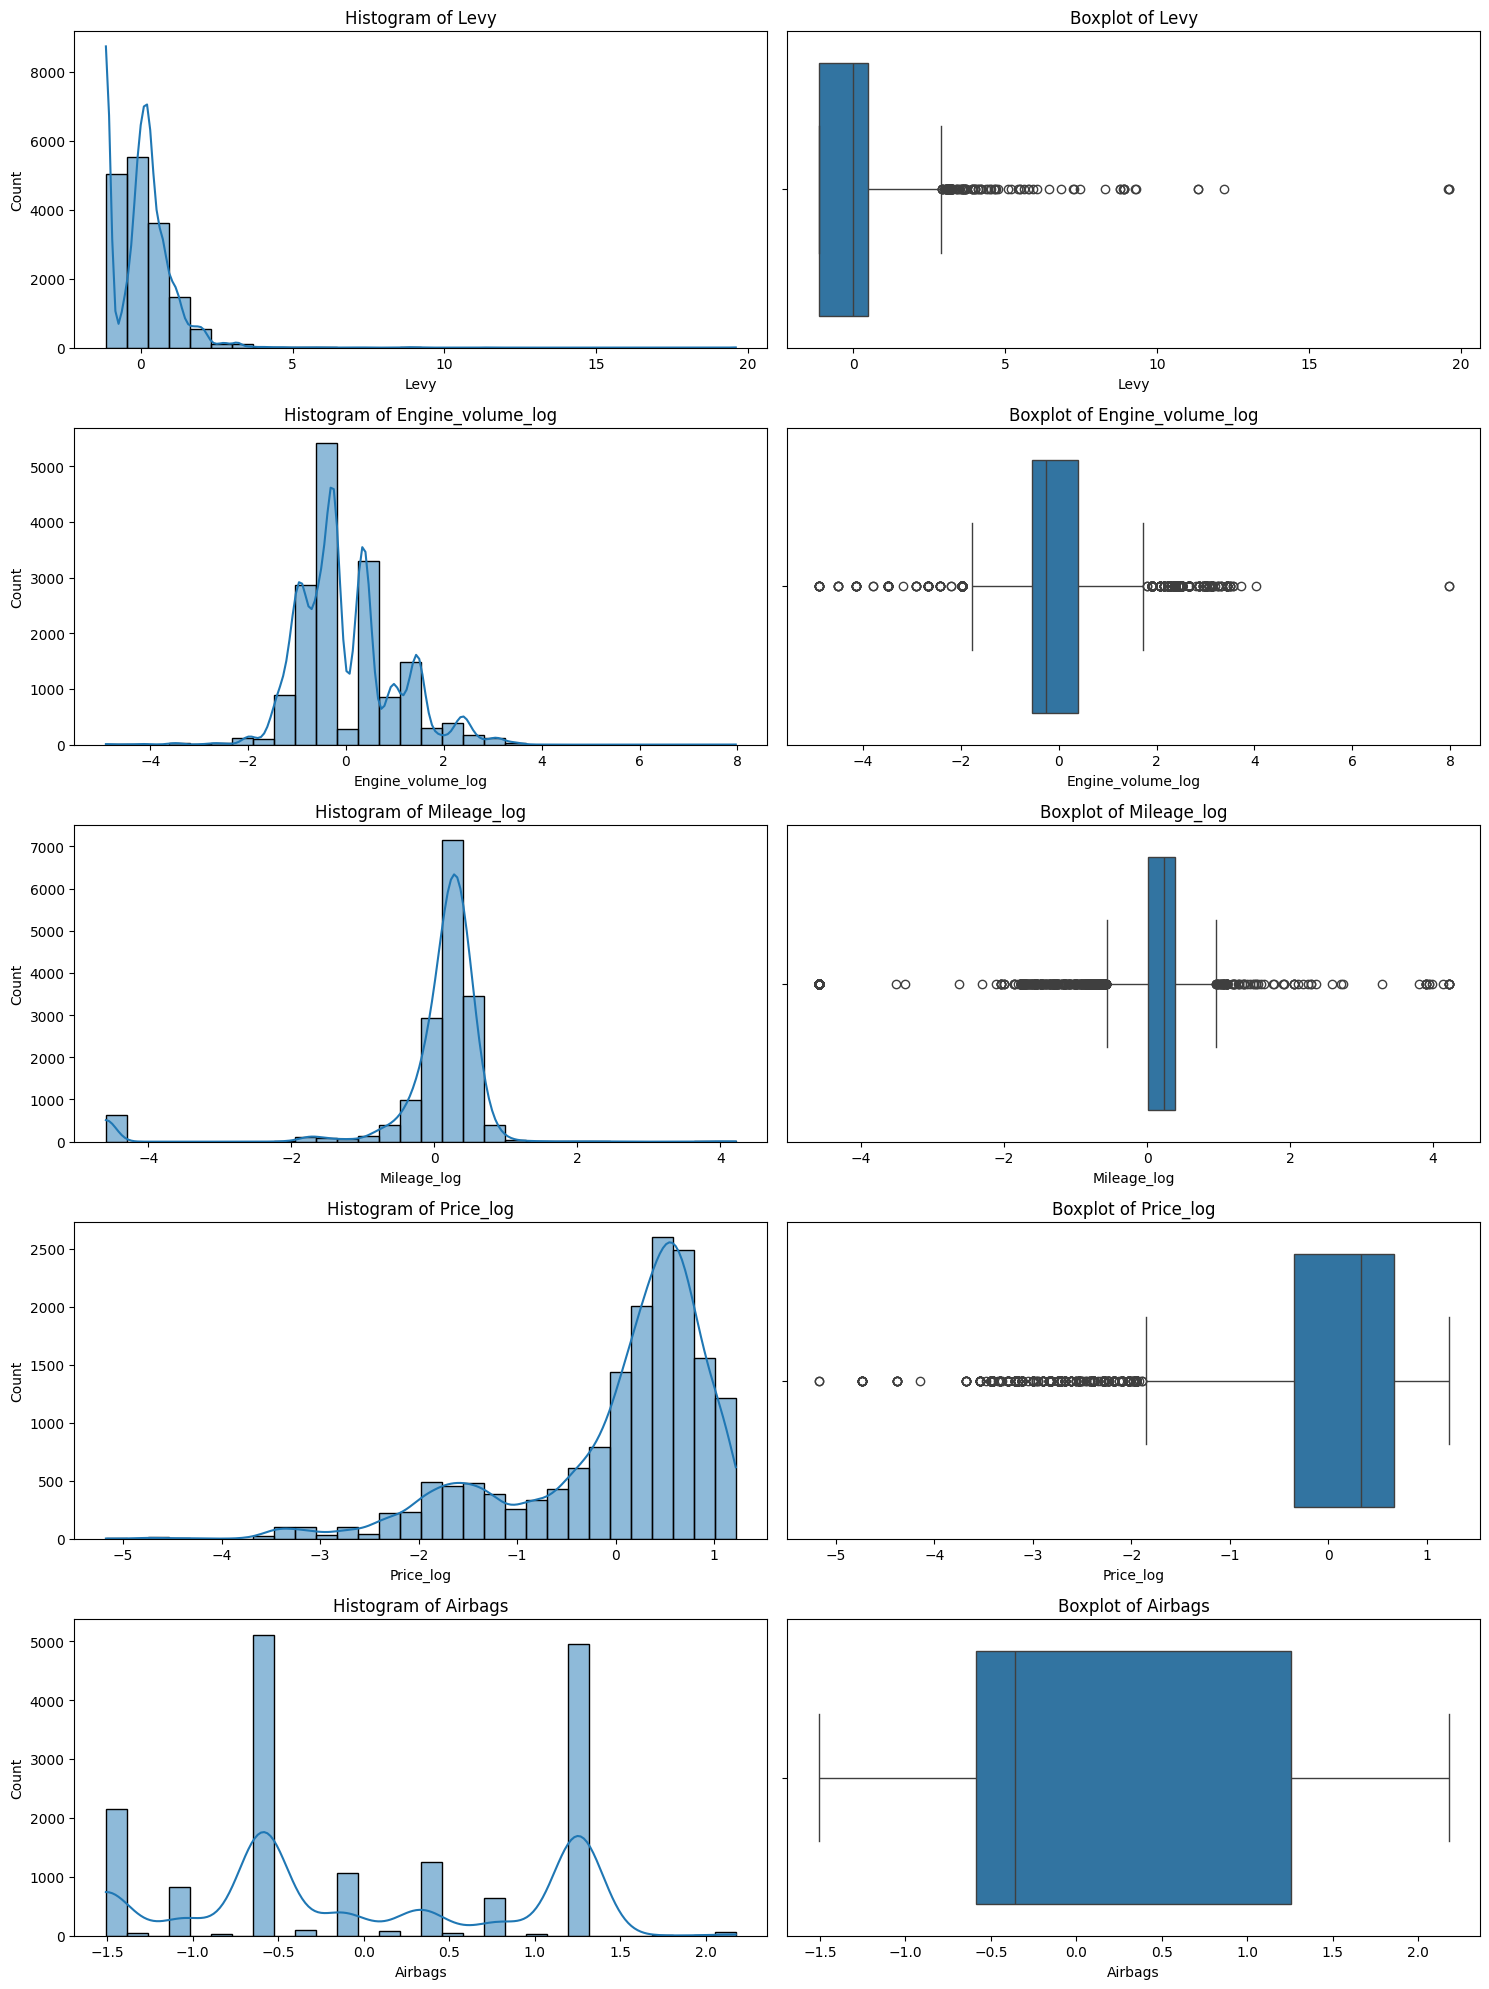

In [24]:
# Apply log transformation to skewed continuous variables
df_cleaned['Price_log'] = np.log1p(df_cleaned['Price'])
df_cleaned['Mileage_log'] = np.log1p(df_cleaned['Mileage'])
df_cleaned['Engine_volume_log'] = np.log1p(df_cleaned['Engine volume'])

# Standardize the numerical features
numerical_features = ['Levy', 'Engine_volume_log', 'Mileage_log', 'Price_log', 'Airbags']
scaler = StandardScaler()
df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])

# Plot histograms and boxplots for the transformed features
plt.figure(figsize=(15, 20))

# Histograms
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 2, 2*i+1)
    sns.histplot(df_cleaned[feature], bins=30, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

    plt.subplot(len(numerical_features), 2, 2*i+2)
    sns.boxplot(x=df_cleaned[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()


In [25]:
df_cleaned.describe()

,Price,Levy,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,...,Drive wheels,Doors,Wheel,Color,Airbags,Mileage_zscore,Manufacturer_encoded,Price_log,Mileage_log,Engine_volume_log
count,16392.000000,1.639200e+04,16392.000000,16392.000000,16392.000000,16392.000000,16392.000000,16392.000000,1.639200e+04,16392.000000,...,16392.000000,16392.000000,16392.000000,16392.000000,1.639200e+04,16392.000000,16392.000000,1.639200e+04,1.639200e+04,1.639200e+04
mean,13273.785200,-2.178183e-17,685.387811,2010.813690,6.310578,0.729746,3.461079,2.287128,1.638846e+06,4.545754,...,0.902330,3.936920,0.084309,7.853892,4.480988e-17,0.001700,32.884273,-5.597171e-16,1.305420e-16,-1.977703e-17
std,11055.560416,1.000031e+00,329.337924,5.593641,2.798326,0.444104,1.777220,0.868413,4.967447e+07,1.142778,...,0.536544,0.370399,0.277860,5.322078,1.000031e+00,1.027506,17.537830,1.000031e+00,1.000031e+00,1.000031e+00
min,1.000000,-1.146280e+00,0.000000,1939.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,...,0.000000,2.000000,0.000000,0.000000,-1.507567e+00,-0.032199,0.000000,-5.174891e+00,-4.592458e+00,-4.907454e+00
25%,3920.000000,-1.146280e+00,431.000000,2009.000000,4.000000,0.000000,2.000000,1.800000,7.468800e+04,4.000000,...,1.000000,4.000000,0.000000,1.000000,-5.867044e-01,-0.030654,22.000000,-3.467976e-01,6.589641e-03,-5.533708e-01
50%,11447.000000,-4.508731e-03,668.000000,2012.000000,7.000000,1.000000,5.000000,2.000000,1.299290e+05,4.000000,...,1.000000,4.000000,0.000000,7.500000,-3.564888e-01,-0.029512,31.000000,3.355899e-01,2.335126e-01,-2.616119e-01
75%,19287.000000,4.734421e-01,976.000000,2014.000000,9.000000,1.000000,5.000000,2.500000,1.900000e+05,4.000000,...,1.000000,4.000000,0.000000,12.000000,1.255021e+00,-0.028269,54.000000,6.678254e-01,3.892722e-01,3.902648e-01
max,45928.000000,1.958970e+01,1271.000000,2020.000000,10.000000,1.000000,6.000000,20.000000,2.147484e+09,16.000000,...,2.000000,5.000000,1.000000,15.000000,2.175883e+00,44.388044,63.000000,1.220384e+00,4.214382e+00,7.967306e+00


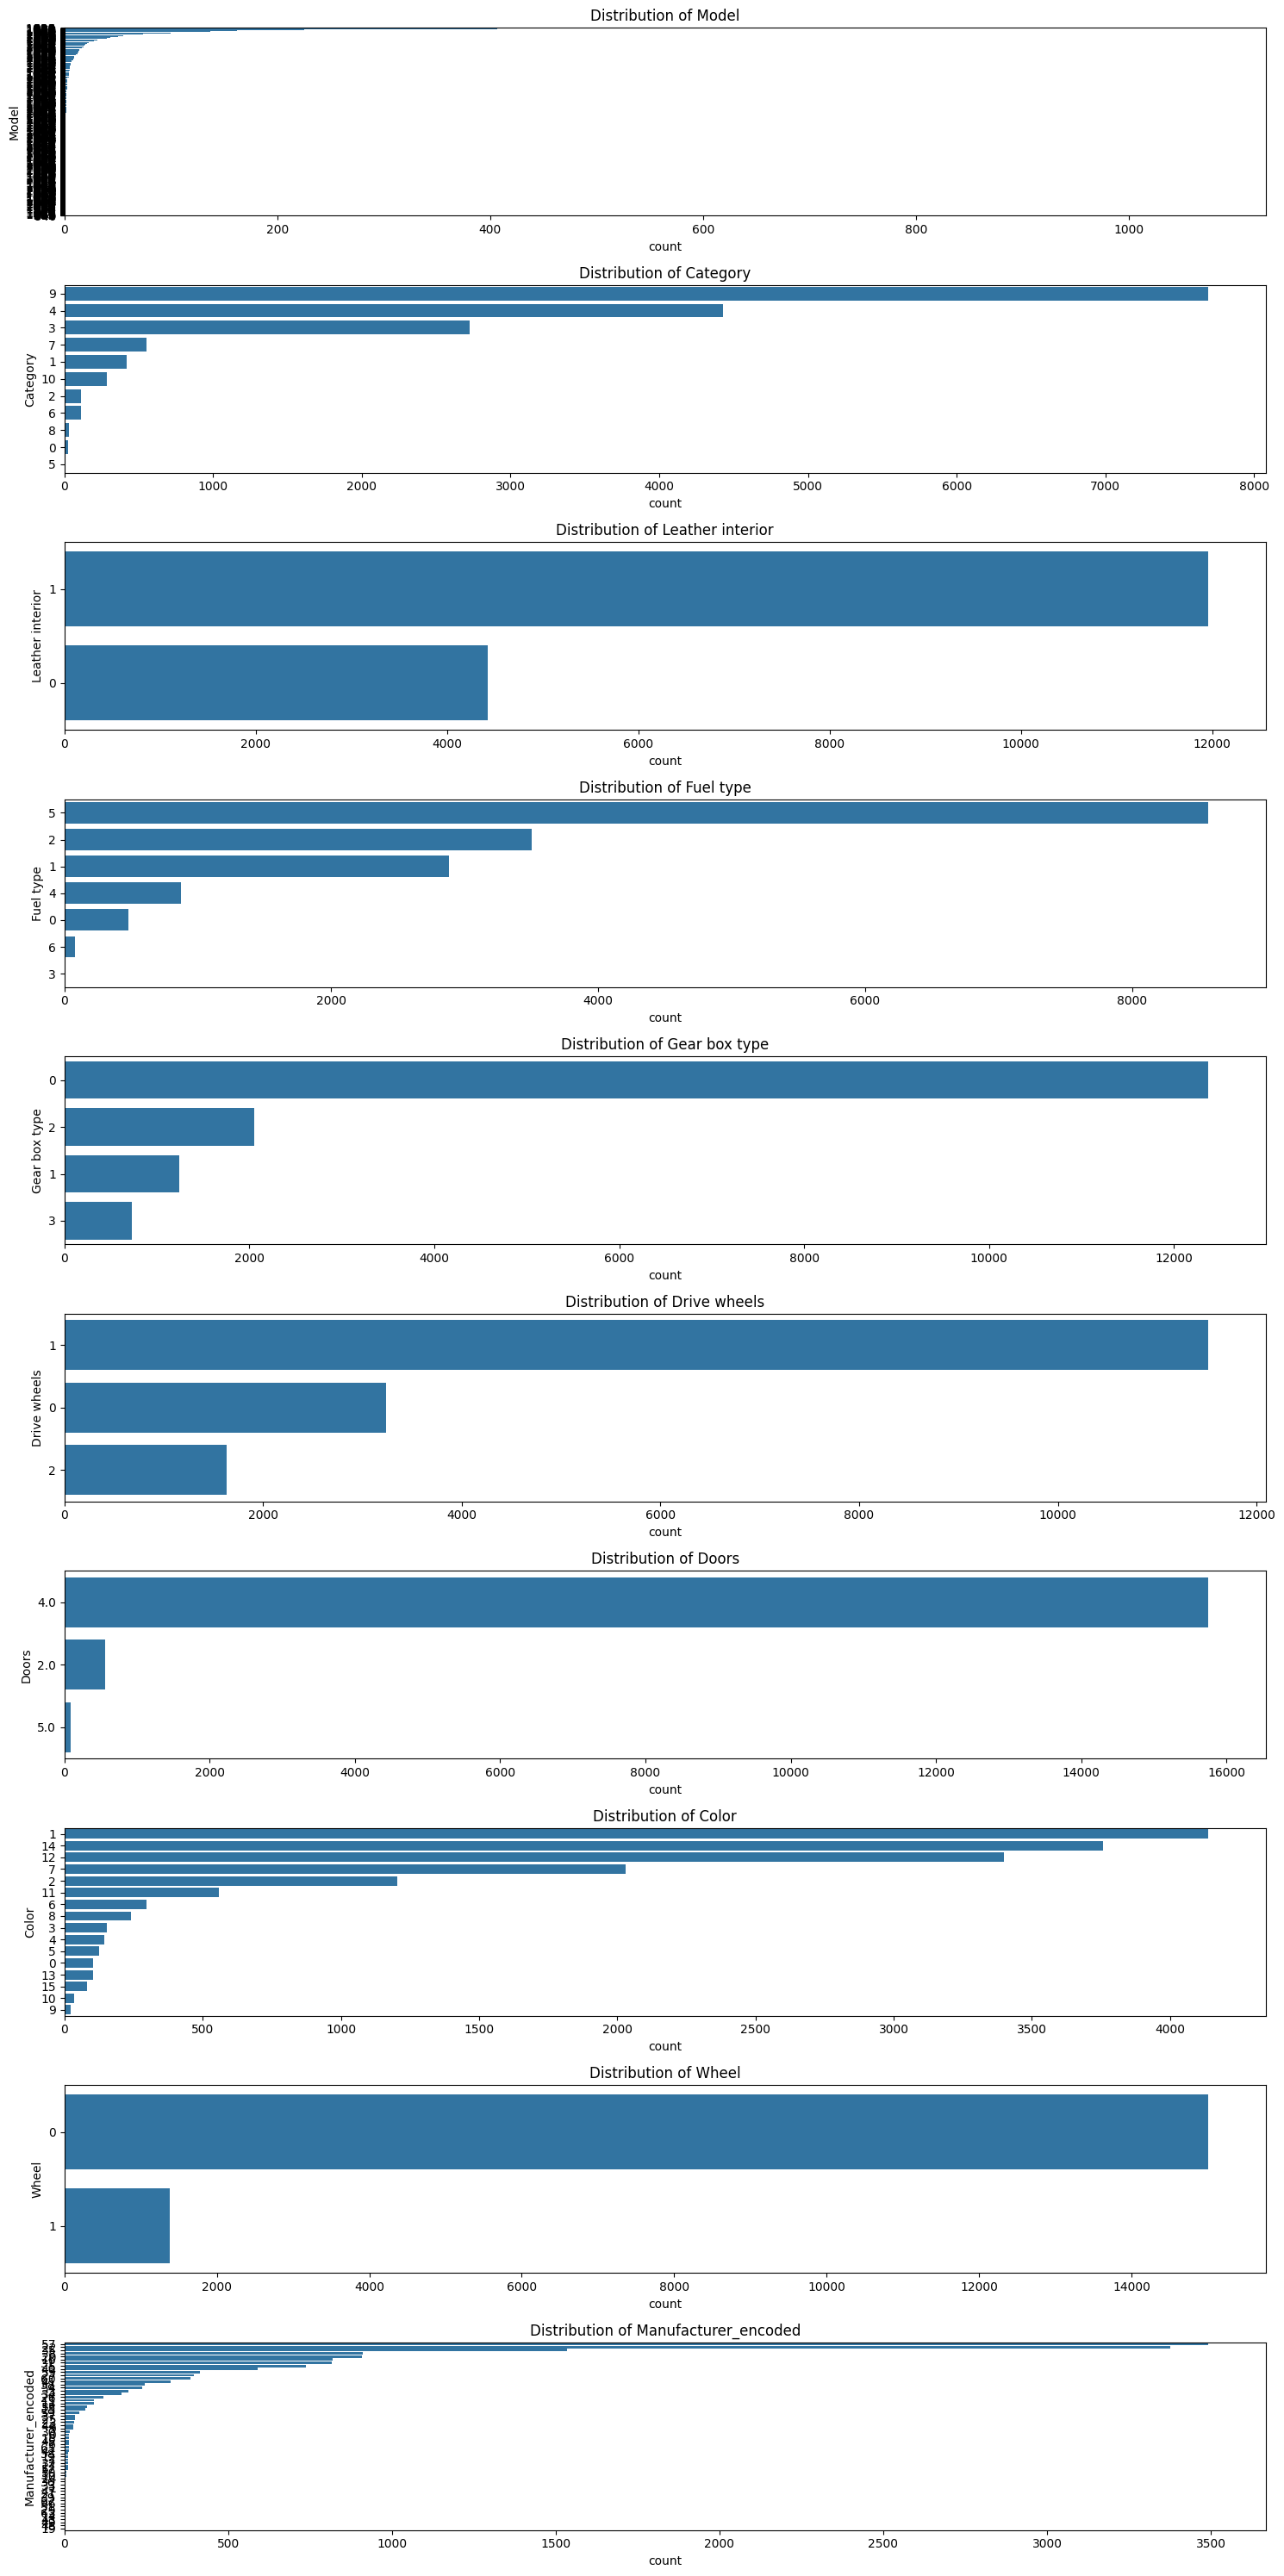

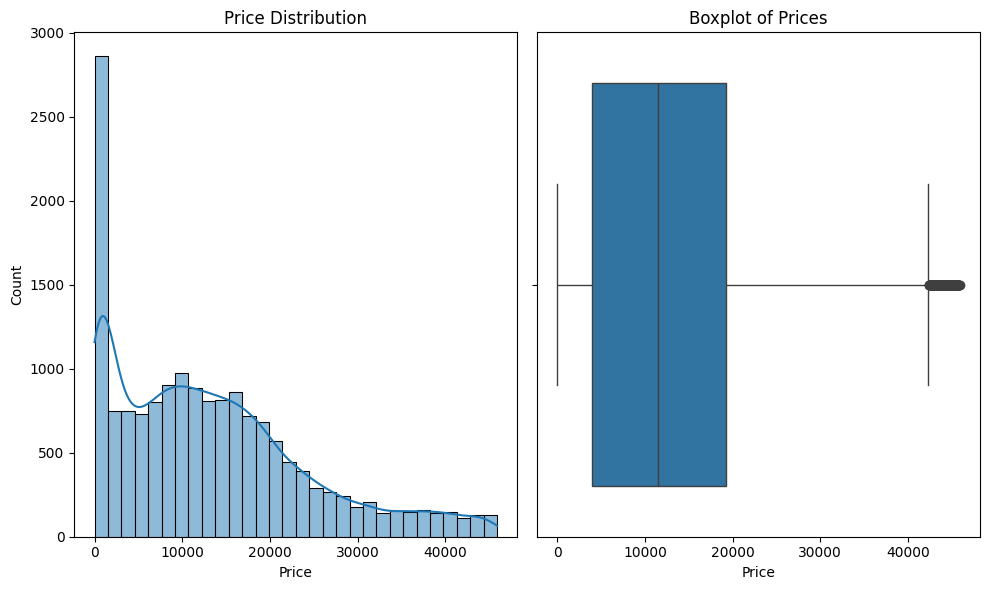

In [26]:
# Update the list of categorical features
categorical_features = ['Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Color', 'Wheel', 'Manufacturer_encoded']

plt.figure(figsize=(15, 30))

# Generate a histogram for each categorical feature
for i, feature in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.countplot(y=feature, data=df_cleaned, order=df_cleaned[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

# Show the count distributions
plt.show()

# Distribution of Price
plt.figure(figsize=(10, 6))

# Histogram for Price
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

# Boxplot for Price
plt.subplot(1, 2, 2)
sns.boxplot(x='Price', data=df_cleaned)
plt.title('Boxplot of Prices')
plt.xlabel('Price')

plt.tight_layout()
plt.show()


###### Much of our *cleaned* data is heavily skewed - thus we need to perform some more pre-processing in order to attain a more honest dataset.

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the features (X) and the target (y)
X = df_cleaned.drop(columns=['Price','Price_log'], axis=1)
y = df_cleaned['Price']

# Split the data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [30]:
# Removed the 'auto' attribute from the max_features parameter
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_distributions,
                               n_iter=100,  # Number of parameter settings sampled
                               cv=3,  # Number of folds in cross-validation
                               verbose=2,  # Controls verbosity of output
                               random_state=42,
                               n_jobs=-1)  # Use all available cores

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get the best parameters and best score from the RandomizedSearchCV
best_params = rf_random.best_params_
best_score = rf_random.best_score_

# Print the best parameters and the best score
print(f"Best Parameters: {best_params}")
print(f"Best Score (Negative MAPE): {best_score}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Score (Negative MAPE): 0.7535380401221489


In [32]:
# Evaluate the model on the validation set
y_val_pred = rf_random.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

# Print the validation MAPE
print(f"Validation MAPE: {val_mape * 100:.2f}%")

# Evaluate the model on the test set
y_test_pred = rf_random.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the test MAPE
print(f"Test MAPE: {test_mape * 100:.2f}%")

Validation MAPE: 990.61%
Test MAPE: 525.32%


#### MAPE scores are still relatively high, must conduct some further feature engineering to handle the skewness of the various categorical features.  

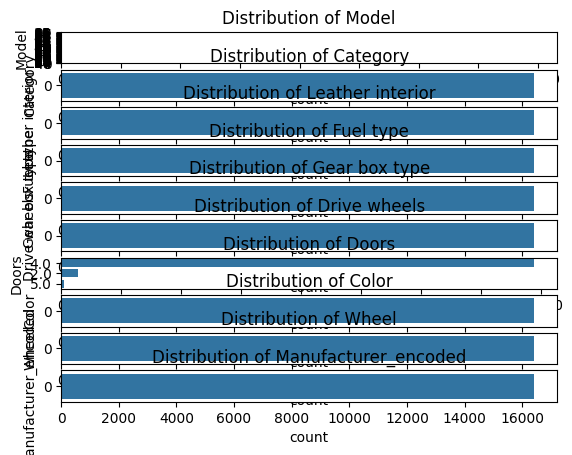

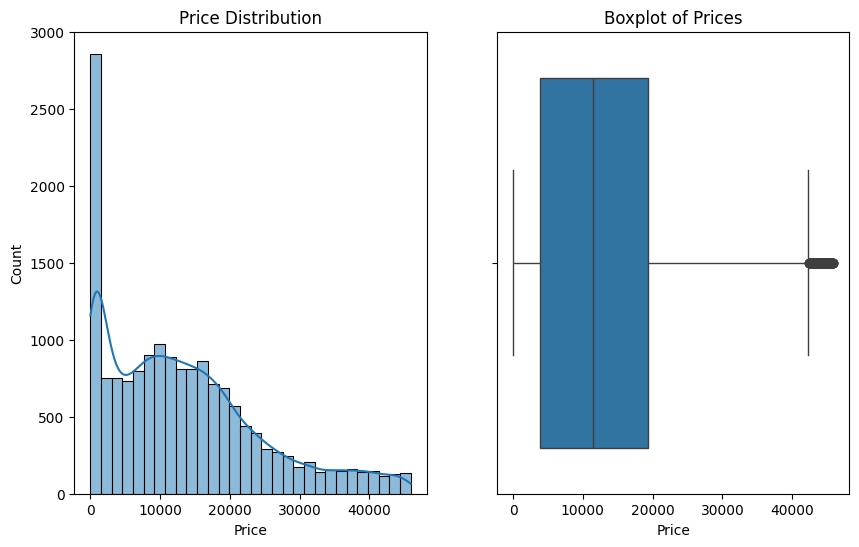

In [42]:
# Generate a histogram for each categorical feature
for i, feature in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.countplot(y=feature, data=df_cleaned, order=df_cleaned[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')

# Show the count distributions
plt.show()

# Distribution of Price
plt.figure(figsize=(10, 6))

# Histogram for Price
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

# Boxplot for Price
plt.subplot(1, 2, 2)
sns.boxplot(x='Price', data=df_cleaned)
plt.title('Boxplot of Prices')
plt.xlabel('Price')

plt.show()

#### Many prices are in the $0-1000 range, lets remove those and see how it improves. 

In [27]:
df_cleaned = df_cleaned[df_cleaned['Price'] > 1000]
print(df_cleaned.describe())

              Price          Levy         Model    Prod. year      Category  \
count  13844.000000  13844.000000  13844.000000  13844.000000  13844.000000   
mean   15638.244438     -0.066314    687.013869   2010.616729      6.337041   
std    10427.887269      0.982520    333.143358      5.673051      2.810947   
min     1019.000000     -1.146280      0.000000   1953.000000      0.000000   
25%     7840.000000     -1.146280    421.000000   2009.000000      4.000000   
50%    13799.000000     -0.013360    668.000000   2012.000000      7.000000   
75%    21012.000000      0.430958    976.000000   2014.000000      9.000000   
max    45928.000000     19.589704   1271.000000   2020.000000     10.000000   

       Leather interior     Fuel type  Engine volume       Mileage  \
count      13844.000000  13844.000000   13844.000000  1.384400e+04   
mean           0.699075      3.459766       2.233054  1.672110e+06   
std            0.458677      1.801991       0.824504  4.999739e+07   
min     

In [28]:
df_cleaned = df_cleaned.drop(columns=['car_age'])

KeyError: "['car_age'] not found in axis"

In [51]:
df_cleaned = df_cleaned.drop(columns=['mileage_per_year'])

In [29]:
negative = df_cleaned[df_cleaned['Levy'] < 0]
print(negative)

       Price      Levy  Model  Prod. year  Category  Leather interior  \
2       8467 -1.146280    545        2006         3                 0   
4      11726 -0.356776    545        2014         3                 1   
8       1098 -0.448826    343        2014         9                 1   
9      26657 -1.146280    998        2007         4                 1   
11      8781 -1.146280   1149        1999         6                 0   
...      ...       ...    ...         ...       ...               ...   
19221  15681 -1.146280    721        2013         9                 1   
19222  10036 -0.015130   1084        2014         9                 1   
19223   8781 -1.146280    336        2008         3                 0   
19224  19130 -1.146280    871        2014         9                 1   
19226   7840 -1.146280   1079        2003         9                 1   

       Fuel type  Engine volume  Mileage  Cylinders  ...  Drive wheels  Doors  \
2              5            1.3   200000  

#### Levy has over 7000 negative values, interpreting this as some kind of rebate or promotion to buy the car? Inspecting the data source did not have any answers. We will leave it in for the next run.

In [30]:
df_cleaned.shape

(13844, 21)

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the features (X) and the target (y)
X = df_cleaned.drop(columns=['Price','Price_log'], axis=1)
y = df_cleaned['Price']

# Split the data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [56]:
# Removed the 'auto' attribute from the max_features parameter
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_distributions,
                               n_iter=100,  # Number of parameter settings sampled
                               cv=3,  # Number of folds in cross-validation
                               verbose=2,  # Controls verbosity of output
                               random_state=42,
                               n_jobs=-1)  # Use all available cores

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get the best parameters and best score from the RandomizedSearchCV
best_params = rf_random.best_params_
best_score = rf_random.best_score_

# Print the best parameters and the best score
print(f"Best Parameters: {best_params}")
print(f"Best Score (Negative MAPE): {best_score}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'bootstrap': True}
Best Score (Negative MAPE): 0.5583264882107727


In [57]:
# Evaluate the model on the validation set
y_val_pred = rf_random.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

# Print the validation MAPE
print(f"Validation MAPE: {val_mape * 100:.2f}%")

# Evaluate the model on the test set
y_test_pred = rf_random.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the test MAPE
print(f"Test MAPE: {test_mape * 100:.2f}%")

Validation MAPE: 58.45%
Test MAPE: 61.95%


##### Vast improvement over the baseline. Let's take a closer look at the distributions once more. 

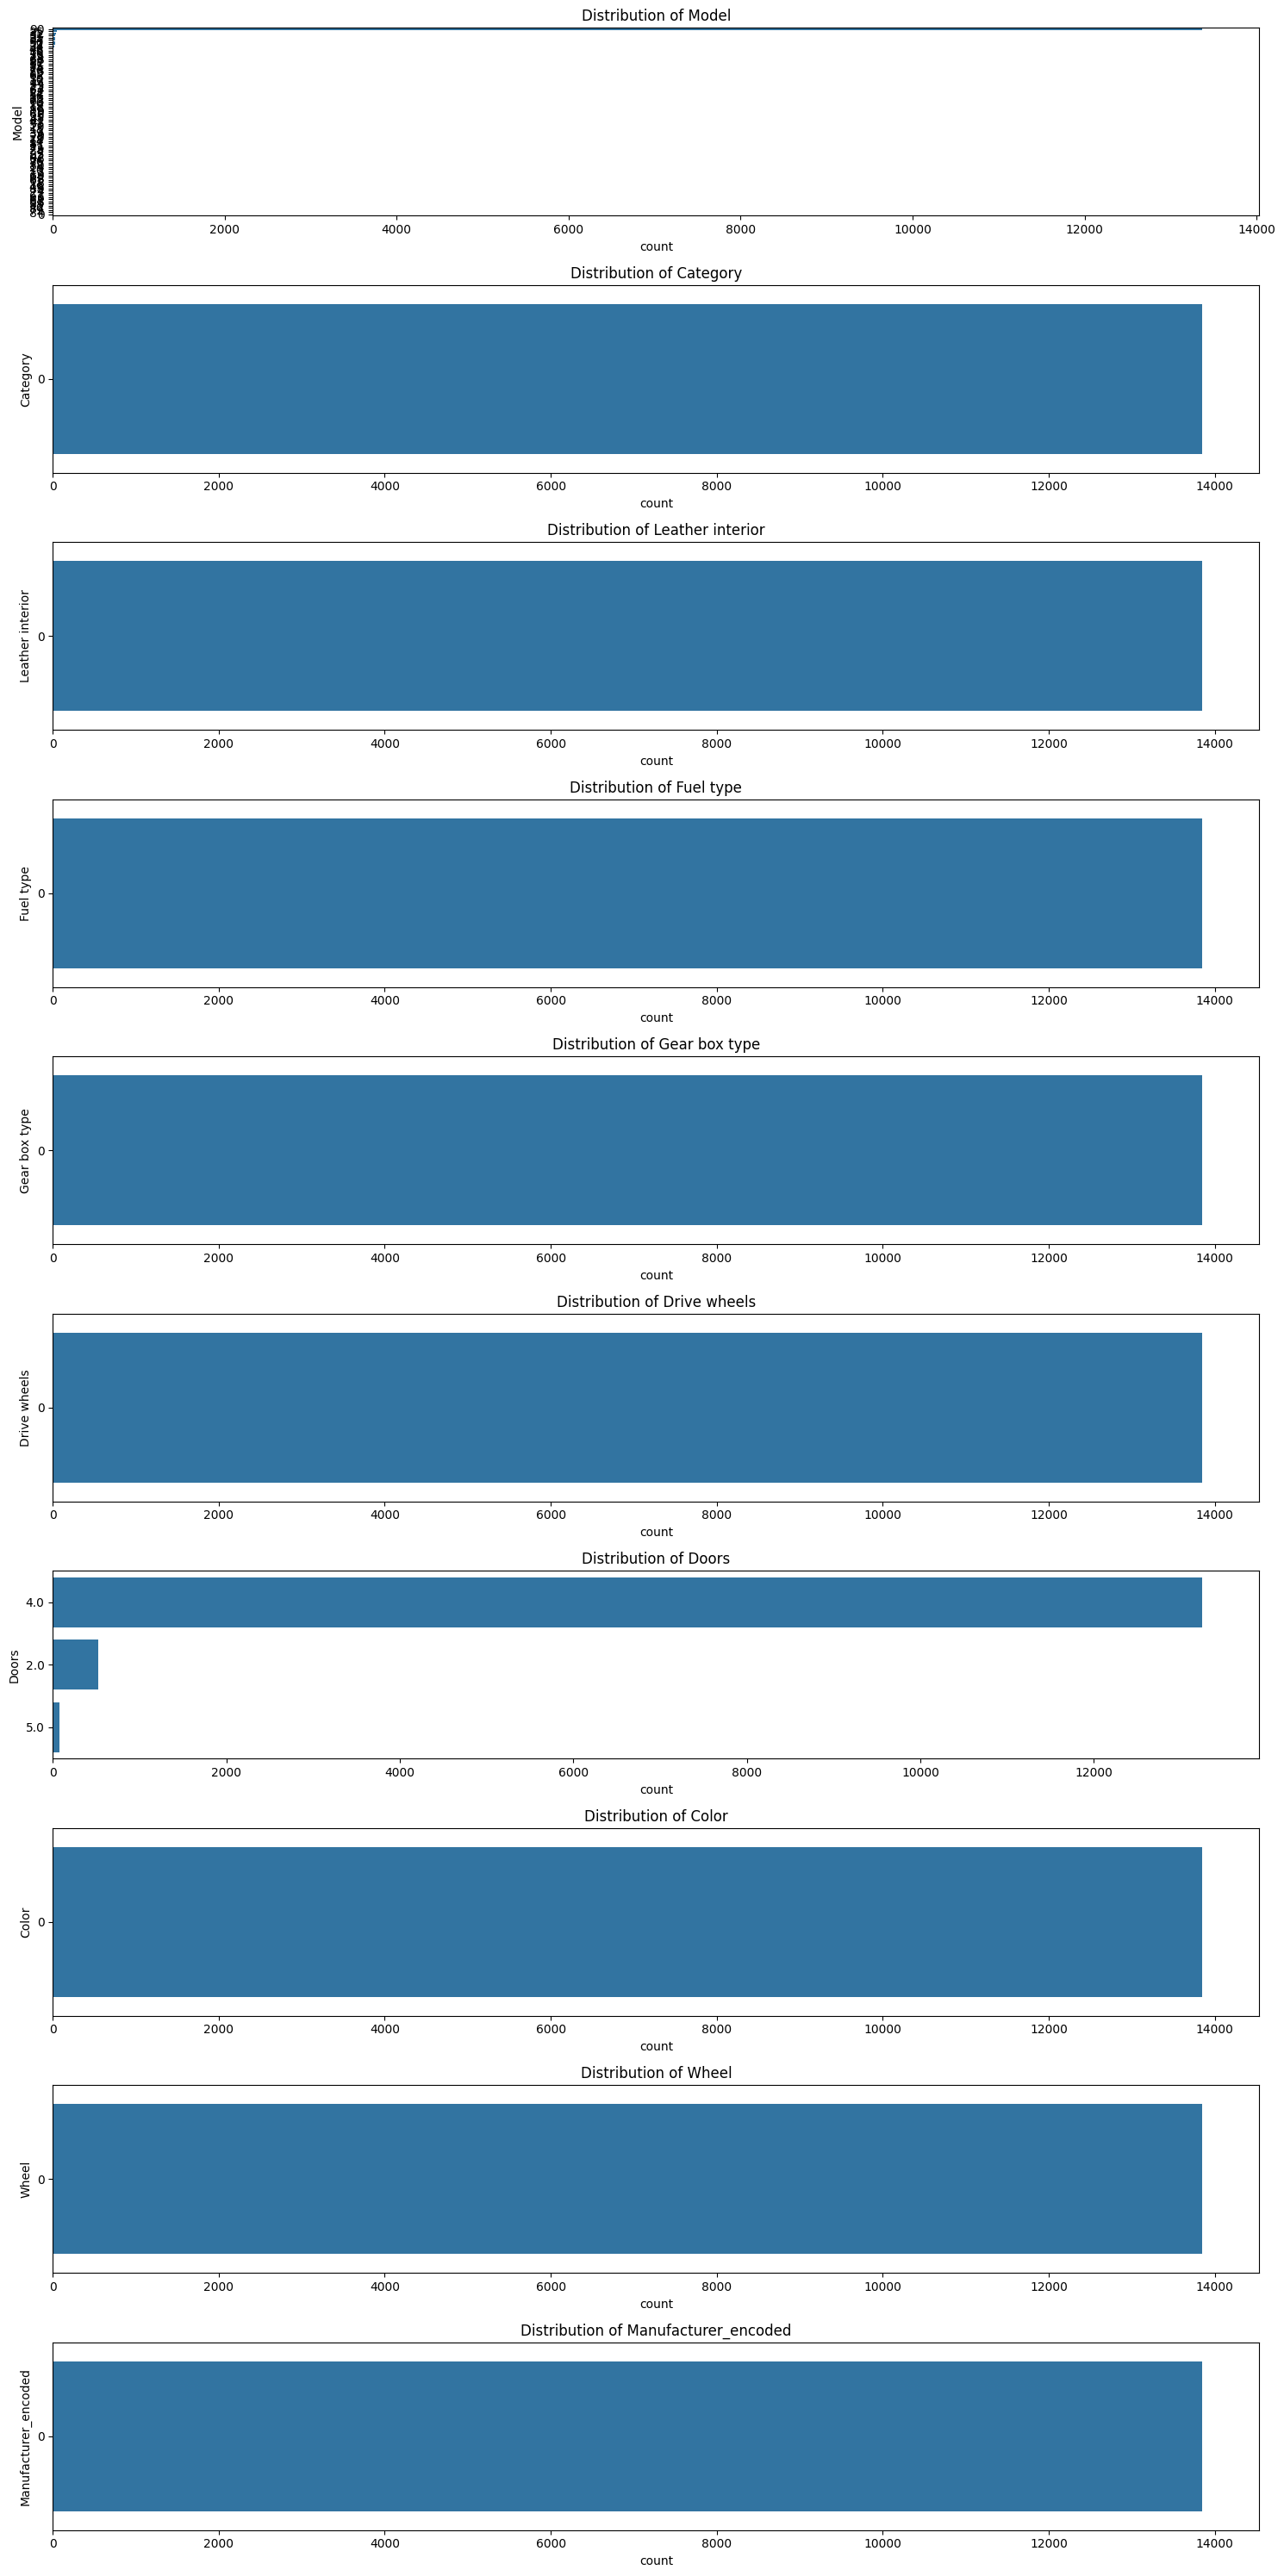

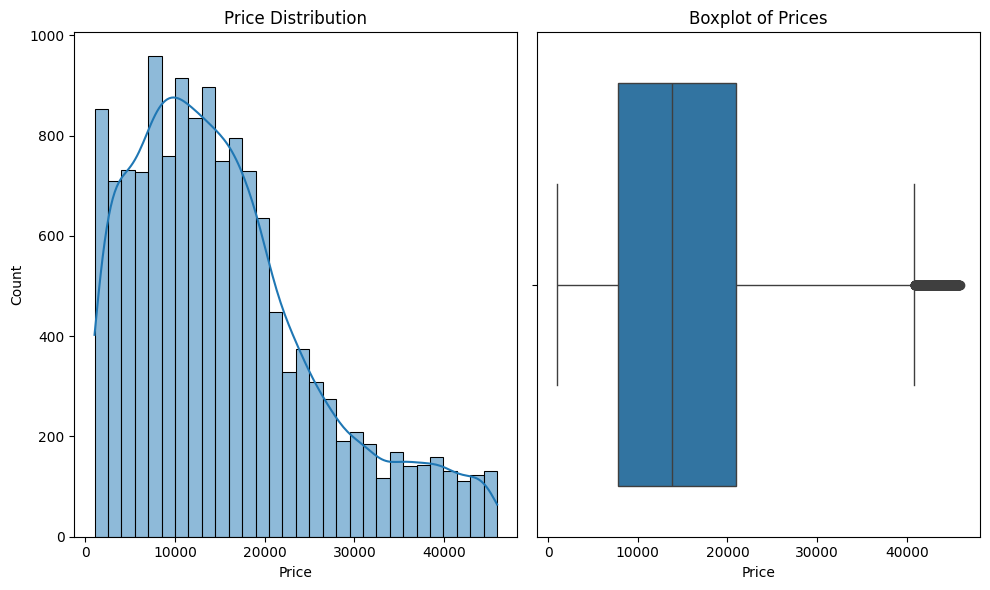

In [58]:
plt.figure(figsize=(15, 30))

# Generate a histogram for each categorical feature
for i, feature in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.countplot(y=feature, data=df_cleaned, order=df_cleaned[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

# Show the count distributions
plt.show()

# Distribution of Price
plt.figure(figsize=(10, 6))

# Histogram for Price
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

# Boxplot for Price
plt.subplot(1, 2, 2)
sns.boxplot(x='Price', data=df_cleaned)
plt.title('Boxplot of Prices')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

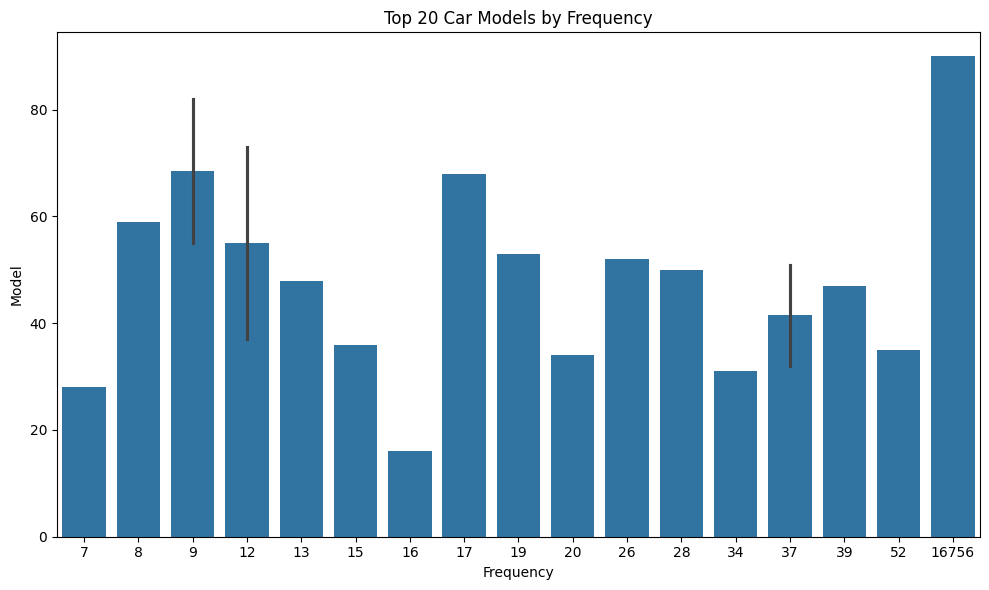

In [62]:
n = 20  # Number of top car models to plot
top_car_models = df['Model'].value_counts().head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Models by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

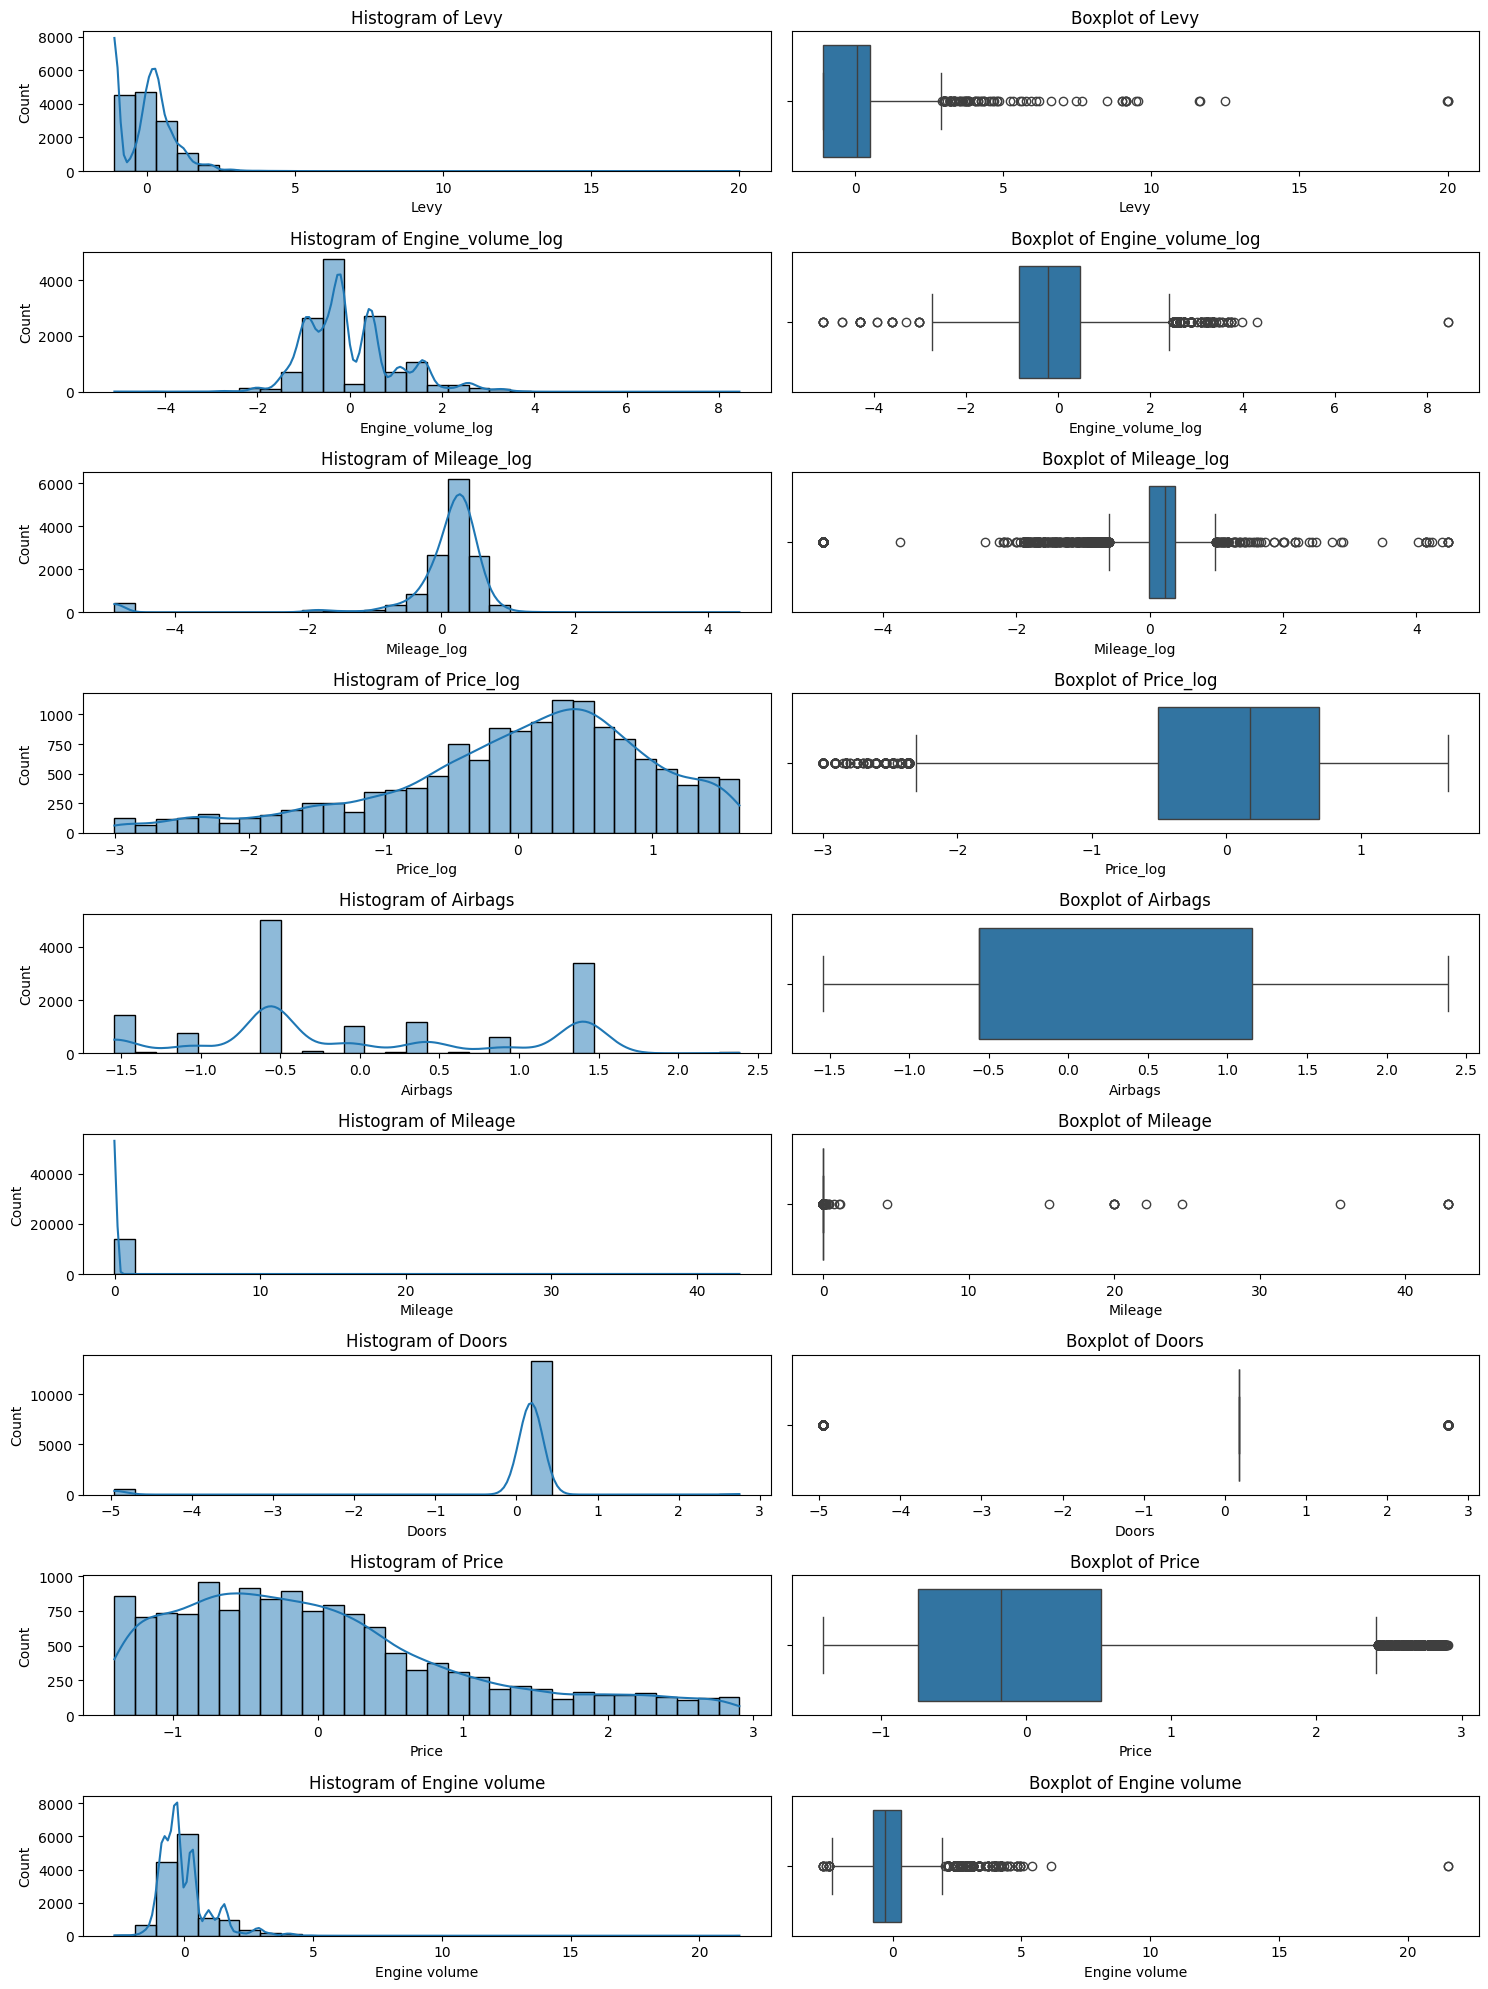

In [34]:
# Update list of numerical features
numerical_features = ['Levy', 'Engine_volume_log', 'Mileage_log', 'Price_log', 'Airbags', 'Mileage', 'Doors', 'Price', 'Engine volume']
scaler = StandardScaler()
df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])

# Plot histograms and boxplots for the transformed features
plt.figure(figsize=(15, 20))

# Histograms
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 2, 2*i+1)
    sns.histplot(df_cleaned[feature], bins=30, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

    plt.subplot(len(numerical_features), 2, 2*i+2)
    sns.boxplot(x=df_cleaned[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [35]:
# Doors cannot be less than 0
print(df_cleaned[df_cleaned['Doors'] < 0])

          Price      Levy  Model  Prod. year  Category  Leather interior  \
11    -0.657611 -1.099220   1149        1999         6                 0   
55    -0.657611 -1.099220    248        2001         1                 0   
97    -1.093669 -1.099220    385        1997         3                 1   
121   -1.168855 -1.099220    389        1995         3                 0   
136    0.004100 -1.099220    891        1997         4                 0   
...         ...       ...    ...         ...       ...               ...   
19041 -1.192830 -1.099220     20        1953         4                 0   
19048 -0.146271  7.657269    292        2002         1                 1   
19078 -0.732797 -1.099220    304        2003         1                 1   
19115 -0.206496 -1.099220     82        2008         1                 1   
19169 -0.146271 -0.243390    104        2012         9                 1   

       Fuel type  Engine volume   Mileage  Cylinders  ...  Drive wheels  \
11          

In [37]:
df_cleaned = df_cleaned[df_cleaned['Doors'] > 0]
print(df_cleaned.describe())

              Price          Levy         Model    Prod. year      Category  \
count  13321.000000  13321.000000  13321.000000  13321.000000  13321.000000   
mean       0.015138      0.019946    693.097290   2010.871856      6.475940   
std        1.002802      0.986427    328.861139      5.391826      2.726559   
min       -1.401988     -1.099220      0.000000   1953.000000      0.000000   
25%       -0.747853     -1.099220    431.000000   2009.000000      4.000000   
50%       -0.157108      0.057502    668.000000   2012.000000      9.000000   
75%        0.530400      0.506137    989.000000   2014.000000      9.000000   
max        2.904793     20.006441   1271.000000   2020.000000     10.000000   

       Leather interior     Fuel type  Engine volume       Mileage  \
count      13321.000000  13321.000000   13321.000000  13321.000000   
mean           0.708731      3.432325      -0.006311      0.001159   
std            0.454364      1.801677       0.986807      1.019458   
min     

In [41]:
df_cleaned.shape

(13321, 21)

In [42]:
# Frequency encoding
def frequency_encoding(df, feature_names):
    transformed_df = df.copy()
    for feature in feature_names:
        freq_encoding = transformed_df[feature].value_counts().to_dict()
        transformed_df[feature + '_freq'] = transformed_df[feature].map(freq_encoding)
    return transformed_df


In [43]:
# Apply frequency encoding to the training set
X_train_encoded = frequency_encoding(X_train, categorical_features)

# Apply the same transformations to the validation and test sets
X_val_encoded = frequency_encoding(X_val, categorical_features)
X_test_encoded = frequency_encoding(X_test, categorical_features)


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
#  Removed the 'auto' attribute from the max_features parameter
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_distributions,
                               n_iter=100,  # Number of parameter settings sampled
                               cv=3,  # Number of folds in cross-validation
                               verbose=2,  # Controls verbosity of output
                               random_state=42,
                               n_jobs=-1)  # Use all available cores

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get the best parameters and best score from the RandomizedSearchCV
best_params = rf_random.best_params_
best_score = rf_random.best_score_

# Print the best parameters and the best score
print(f"Best Parameters: {best_params}")
print(f"Best Score (Negative MAPE): {best_score}")

# Evaluate the model on the validation set
y_val_pred = rf_random.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

# Print the validation MAPE
print(f"Validation MAPE: {val_mape * 100:.2f}%")

# Evaluate the model on the test set
y_test_pred = rf_random.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the test MAPE
print(f"Test MAPE: {test_mape * 100:.2f}%")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Score (Negative MAPE): 0.7616531507210756
Validation MAPE: 993.56%
Test MAPE: 523.83%
